In [1]:
%matplotlib inline
import random

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp

# import xgboost as xgb
from itertools import tee, islice
from ROOT import TFile, TCanvas, TPad, TPaveLabel, TPaveText, TTree, TH1F, TF1
from root_numpy import root2array, tree2array, array2tree, array2root
import sys
from ROOT import gROOT, AddressOf
from root_numpy import root2array, rec2array

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

import matplotlib.ticker as ticker
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import tree

Welcome to JupyROOT 6.16/00


The excellent root_numpy library makes it easy to read your data stored in a ROOT TTree. Each call to root2array will create a 2D array which contains one row per event, and one column representing each branch you want to use.

In [3]:
back = '/afs/cern.ch/user/s/sraj/public/data_folder/output_TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8.root'
signal = '/afs/cern.ch/user/s/sraj/public/data_folder/output_TprimeBToTH_Hgg_M-600_LH_TuneCP5_PSweights_13TeV-madgraph_pythia8.root'
out_dir = '/afs/cern.ch/user/s/sraj/public/plot'
#Calling out the folder in which the data is stored
treeName_back ="tagsDumper/trees/ttgg_13TeV_THQLeptonicTag" 
treeName_signal = "tagsDumper/trees/Tprime_600_13TeV_THQLeptonicTag"
columns = ['dipho_pt','dipho_phi','dipho_eta','dipho_e','dipho_leadPt','dipho_leadEt','dipho_leadEta','dipho_leadPhi']
#Data is converted to array
mc_arr = root2array(back, treeName_back, columns)
data_arr = root2array(signal, treeName_signal, columns)

signal = rec2array(data_arr)
backgr = rec2array(mc_arr)

In [4]:
# for sklearn data is usually organised
# into one 2D array of shape (n_samples x n_features)
# containing all the data and one array of categories
# of length n_samples
X = np.concatenate((signal, backgr))
y = np.concatenate((np.ones(signal.shape[0]),
                    np.zeros(backgr.shape[0])))

In [5]:
X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                              test_size=0.33, random_state=42)
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev,
                                                  test_size=0.33, random_state=410)

In [6]:
clf = AdaBoostClassifier(base_estimator= tree.DecisionTreeClassifier(max_depth=2),
                          n_estimators=100, random_state=1,learning_rate=1)
# Fit the decision tree classifier
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=100, random_state=1)

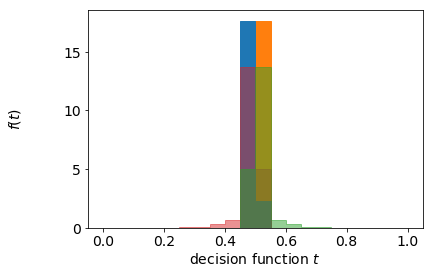

In [7]:
plt.figure()                                     # new window
matplotlib.rcParams.update({'font.size':14})     # set all font sizes
tTest = clf.predict_proba(X_test)
# if hasattr(clf, "decision_function"):
#     tTest = clf.decision_function(X_test)        # if available use decision_function
# else:
#     tTest = clf.predict_proba(X_test)[:,1]       # for e.g. MLP need to use predict_proba
tBkg = tTest[y_test==0]
tSig = tTest[y_test==1]
nBins = 20
tMin = np.floor(np.min(tTest))
tMax = np.ceil(np.max(tTest))
bins = np.linspace(tMin, tMax, nBins+1)
plt.xlabel('decision function $t$', labelpad=3)
plt.ylabel('$f(t)$', labelpad=40)
n, bins, patches = plt.hist(tSig, bins=bins, density=True, histtype='step', fill=True, )
n, bins, patches = plt.hist(tBkg, bins=bins, density=True, histtype='step', fill=True, alpha=0.5)
plt.show()

A DataFrame is a 2-dimensional labeled data structure with columns of potentially different types. You can think of it like a spreadsheet or a ROOT TTree

In [8]:
import pandas.core.common as com
from pandas.core.index import Index


from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

In [9]:
# Create a pandas DataFrame for our data
# this provides many convenience functions
# for exploring your dataset
# need to reshape y so it is a 2D array with one column

In [10]:
columns = [c.strip() for c in columns]
columnscolumns = (b.replace(" ", "_") for b in columns)
columns = list(b.replace("-", "_") for b in columns)

In [13]:
df = pd.DataFrame(np.hstack((X, y.reshape(y.shape[0], -1))),
                  columns=branch_names+['y'])

NameError: name 'branch_names' is not defined

In [12]:
df.boxplot(by='y',
           column=["dipho_pt",
                   "dipho_phi",
                   "dipho_eta",
                   "dipho_e"],
           return_type='axes')

NameError: name 'df' is not defined

The correlation between features can be plotted with df.corr(). For this data set the plots are not the most exciting as the variables are not correlated with each other.



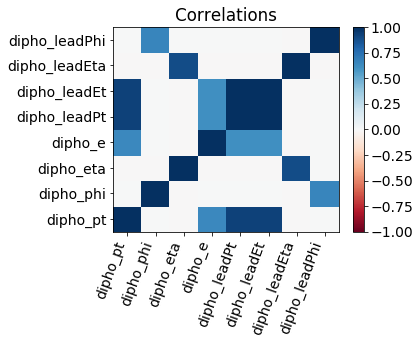

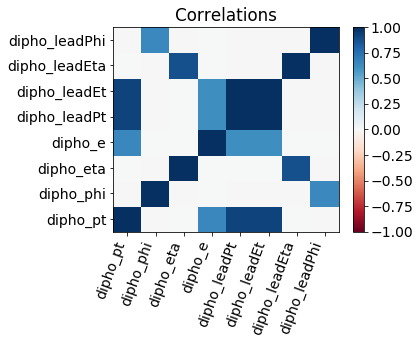

In [40]:
bg = df.y < 0.5
sig = df.y > 0.5

def correlations(data, **kwds):
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    corrmat = data.corr(**kwds)

    fig, ax1 = plt.subplots(ncols=1, figsize=(6,5))
    
    opts = {'cmap': plt.get_cmap("RdBu"),
            'vmin': -1, 'vmax': +1}
    heatmap1 = ax1.pcolor(corrmat, **opts)
    plt.colorbar(heatmap1, ax=ax1)

    ax1.set_title("Correlations")

    labels = corrmat.columns.values
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()
    
# remove the y column from the correlation matrix
# after using it to select background and signal
correlations(df[bg].drop('y', 1))
correlations(df[sig].drop('y', 1))

Here we split our data into two independent samples twice. The first split is to create a development and a evaluation set. All development and performance evaluation will be done with the development set. Once the hyper-parameters and other settings are frozen we can use the evaluation set to get an unbiased estimate of the performance.

The development set is further split into a training and testing set. The first will be used for training the classifier and the second to evaluate its performance.

In [14]:
from sklearn.cross_validation import train_test_split
X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                              test_size=0.33, random_state=42)
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev,
                                                  test_size=0.33, random_state=410)

/cvmfs/sft.cern.ch/lcg/views/LCG_95apython3/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
clf = AdaBoostClassifier(base_estimator= tree.DecisionTreeClassifier(max_depth=3),
                          n_estimators=100, random_state=1,learning_rate=1)
# Fit the decision tree classifier
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=100, random_state=1)

In [16]:
y_predicted = clf.predict(X_test)
print (classification_report(y_test, y_predicted,
                            target_names=["background", "signal"]))
print ("Area under ROC curve: %.4f"%(roc_auc_score(y_test,
                                                  clf.decision_function(X_test))))

             precision    recall  f1-score   support

 background       0.82      0.75      0.78     12398
     signal       0.83      0.88      0.86     17862

avg / total       0.83      0.83      0.83     30260

Area under ROC curve: 0.8863


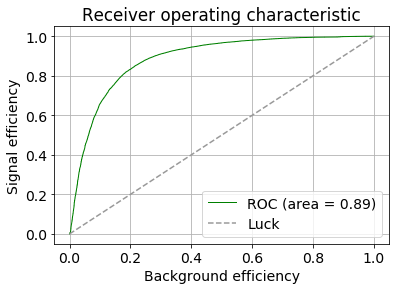

In [29]:
from sklearn.metrics import roc_curve, auc

decisions = clf.decision_function(X_test)
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc), color ='green')

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Background efficiency')
plt.ylabel('Signal efficiency')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('/eos/home-s/sraj/M.Sc._Thesis/Plot/' "adaboost_classifier.png")
# plt.savefig("/eos/home-s/s/sraj/M.Sc._Thesis/Plot/" 'adaboost_classifier.png')
plt.grid()
plt.show()

/cvmfs/sft.cern.ch/lcg/views/LCG_95apython3/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


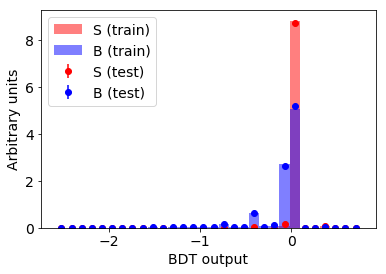

In [25]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5,range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(clf, X_train, y_train, X_test, y_test)